In [ ]:
# Create a dataset that contains the monthly means of Sea Surface Temperature anomalies and total column water vapor from Jan 1979-Dec 2023 over the Pacific Basin (65°N to 65°S, 120°E to 60°W)
 #masked out over land - save this to your computer.
 #Plot maps of the mean SST and mean total column water vapor for the entire period of record.

In [ ]:
from dask.distributed import Client, progress
client = Client(dashboard_address=':5555')  
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:5555/status,
Dashboard: http://127.0.0.1:5555/status,Workers: 4
Total threads: 12,Total memory: 15.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61016,Workers: 4
Dashboard: http://127.0.0.1:5555/status,Total threads: 12
Started: Just now,Total memory: 15.79 GiB
Comm: tcp://127.0.0.1:61037,Total threads: 3
Dashboard: http://127.0.0.1:61041/status,Memory: 3.95 GiB
Nanny: tcp://127.0.0.1:61019,


2024-03-08 19:55:54,103 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:61036', name: 2, status: running, memory: 0, processing: 0>
2024-03-08 19:55:54,107 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:61038', name: 3, status: running, memory: 0, processing: 0>
2024-03-08 19:55:54,112 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:61038'.
2024-03-08 19:55:54,116 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:61036'.
2024-03-08 23:58:05,816 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:61037 (pid=15720) exceeded 95% memory budget. Restarting...
2024-03-08 23:58:06,412 - distributed.nanny - WARNING - Restarting worker
2024-03-09 00:00:53,700 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:63507 (pid=15596) exceed

In [4]:
# Import libraries

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os

In [5]:
degree_step_size= 4

In [7]:
filename = 'era5data_pacificbasin_sst_vapor.nc'

if os.path.exists(filename):
    # Read saved data
    ds= xr.open_dataset(filename)

else:
    # Pull the data only if not available locally
    ds = xr.open_dataset('https://thredds.rda.ucar.edu/thredds/dodsC/aggregations/g/ds633.1/2/TP',
                     chunks={'time':'500MB'})

    variables = ['Total_column_water_vapour_surface_Mixed_intervals_Average','Sea_surface_temperature_surface_Mixed_intervals_Average']
    
    #select the two needed variables every 4th point to get 1 degree resolution
    ds = ds[variables].sel(lat=slice(65, -65, degree_step_size), lon=slice(120, 300, degree_step_size))
    ds.to_netcdf(filename)

In [9]:
ds

<xarray.Dataset> Size: 97MB
Dimensions:                                                    (time: 516,
                                                                lat: 130,
                                                                lon: 181)
Coordinates:
  * lat                                                        (lat) float32 520B ...
  * lon                                                        (lon) float32 724B ...
  * time                                                       (time) datetime64[ns] 4kB ...
    reftime                                                    (time) datetime64[ns] 4kB dask.array<chunksize=(516,), meta=np.ndarray>
Data variables:
    Total_column_water_vapour_surface_Mixed_intervals_Average  (time, lat, lon) float32 49MB dask.array<chunksize=(120, 130, 181), meta=np.ndarray>
    Sea_surface_temperature_surface_Mixed_intervals_Average    (time, lat, lon) float32 49MB dask.array<chunksize=(120, 130, 181), meta=np.ndarray>
Attributes:
    Originating_or_generating_Center:     European Centre for Medium Range We...
    Originating_or_generating_Subcenter:  0
    GRIB_table_version:                   0,128
    file_format:                          GRIB-1
    Conventions:                          CF-1.6
    history:                              Read using CDM IOSP GribCollection v3
    featureType:                          GRID
    _CoordSysBuilder:                     ucar.nc2.dataset.conv.CF1Convention

In [20]:
sst_avg= ds["Sea_surface_temperature_surface_Mixed_intervals_Average"]
#sst_avg= sst_avg/10
sst_avg.head(10)

<xarray.DataArray 'Sea_surface_temperature_surface_Mixed_intervals_Average' (
                                                                             time: 10,
                                                                             lat: 10,
                                                                             lon: 10)> Size: 4kB
dask.array<getitem, shape=(10, 10, 10), dtype=float32, chunksize=(10, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 40B 64.75 63.75 62.75 61.75 ... 57.75 56.75 55.75
  * lon      (lon) float32 40B 120.0 121.0 122.0 123.0 ... 127.0 128.0 129.0
  * time     (time) datetime64[ns] 80B 1979-01-16T12:00:00 ... 1979-10-16T12:...
    reftime  (time) datetime64[ns] 80B dask.array<chunksize=(10,), meta=np.ndarray>
Attributes: (12/15)
    long_name:                       Sea surface temperature (Mixed_intervals...
    units:                           K
    description:                     v-component of wind
    grid_mapping:                    LatLon_Projection
    Grib_Statistical_Interval_Type:  Average
    Grib_Variable_Id:                VAR_98-0-128-34_L1_Imixed_S123
    ...                              ...
    Grib1_Parameter:                 34
    Grib1_Parameter_Name:            sst
    Grib1_Level_Type:                1
    Grib1_Level_Desc:                Ground or water surface
    Grib1_Interval_Type:             123
    Grib1_Interval_Name:             Average of N uninitialized analyses, int...

In [14]:
#Finding Sea Surface Temp anomalies
#import pandas as pd

sst_avg_mean_along_lat_lon = sst_avg.mean(dim= ['lon','lat'])

sst_avg_mean_along_lat_lon.to_pandas()
ninety_five_percentile_sst = np.percentile(sst_avg_mean_along_lat_lon.to_pandas().to_numpy(), 95, method="inverted_cdf")
print("The 95%-value is --", ninety_five_percentile_sst)

The 95%-value is -- 291.96896


In [ ]:
#Sea Surface Temp Along time
sst_avg_mean_along_time = sst_avg.mean(dim= ['time'])
sst_anomalies = sst_avg_mean_along_time.where(sst_avg_mean_along_time>= ninety_five_percentile_sst, drop =True)


In [21]:
#Land Sea Mask

url = "https://thredds.rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc"

ds_lsm = xr.open_dataset(url)[["LSM"]]
ds_lsm = ds_lsm.rename({"latitude": "lat", "longitude": "lon"})

ds_lsm = ds_lsm.sel(lat=slice(64.9, -65, degree_step_size), lon=slice(120, 300, degree_step_size))
ds_lsm = ds_lsm.mean(dim=['time'])
ds_lsm

<xarray.Dataset> Size: 97kB
Dimensions:  (lat: 130, lon: 181)
Coordinates:
  * lat      (lat) float64 1kB 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float64 1kB 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
Data variables:
    LSM      (lat, lon) float32 94kB 0.982 0.9716 0.9474 ... 0.1706 0.533 1.0

In [22]:
#Plotting the Anamalies

import warnings

import matplotlib.pyplot as plt
import numpy as np
import cartopy
from cartopy import crs as ccrs, feature as cfeature

Jan 1979-Dec 2023

In [ ]:
#Land Sea Mask

url = "https://thredds.rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc"

ds_lsm = xr.open_dataset(url)[["LSM"]]
ds_lsm = ds_lsm.rename({"latitude": "lat", "longitude": "lon"})

ds_lsm = ds_lsm.sel(lat=slice(64.9, -65, degree_step_size), lon=slice(120, 300, degree_step_size))
ds_lsm = ds_lsm.mean(dim=['time'])
ds_lsm["lat"] = sst_avg_mean_along_time["lat"]
ds_lsm["lon"] = sst_avg_mean_along_time["lon"]



In [93]:
ds_lsm

<xarray.Dataset> Size: 97kB
Dimensions:  (lat: 130, lon: 181)
Coordinates:
  * lat      (lat) float64 1kB 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float64 1kB 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
Data variables:
    LSM      (lat, lon) float32 94kB 0.982 0.9716 0.9474 ... 0.1706 0.533 1.0

In [16]:
sst_avg_mean_along_time

<xarray.DataArray 'Sea_surface_temperature_surface_Mixed_intervals_Average' (
                                                                             lat: 721,
                                                                             lon: 1440)> Size: 4MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8

In [116]:
sst_avg_lsm = sst_avg_mean_along_time.where(ds_lsm <1, drop=True)

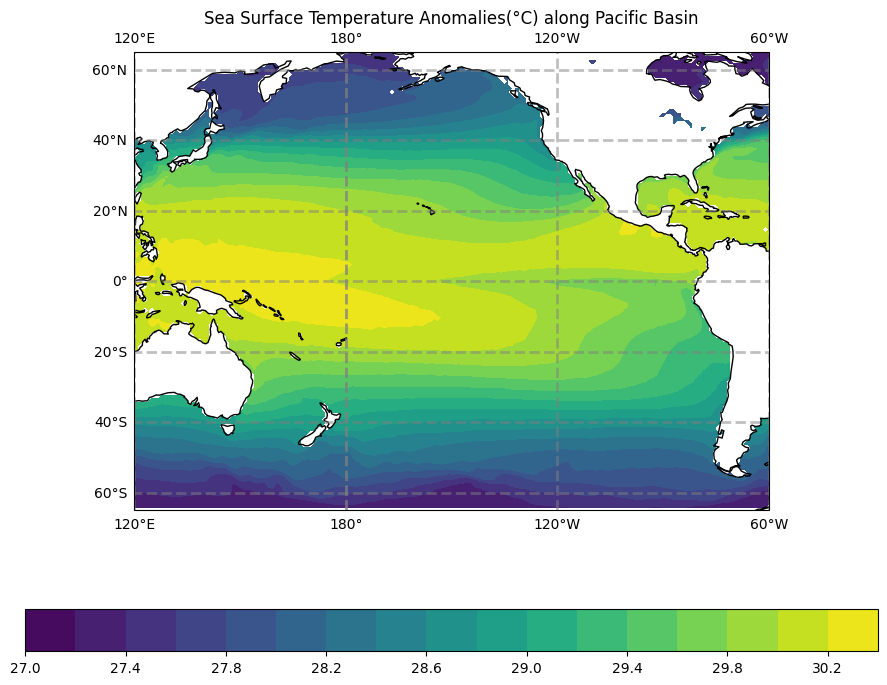

In [138]:

lonW = 120
lonE = 300
latS = -65
latN = 65


crs0 = ccrs.PlateCarree(central_longitude=0)
crs_pacific = ccrs.PlateCarree(central_longitude=-150)

res = '110m'
fig = plt.figure(figsize=(11, 8.5))
ax = plt.subplot(1, 1, 1, projection=crs_pacific)
ax.set_title('Sea Surface Temperature Anomalies(°C) along Pacific Basin')
gl = ax.gridlines(
    draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--'
)
ax.set_extent([lonW, lonE, latS, latN], crs=crs0)
ax.coastlines(resolution=res, color='black')
lon, lat = np.meshgrid(sst_avg_lsm["lon"].to_numpy(),
                       sst_avg_lsm["lat"].to_numpy())
data = sst_avg_lsm.to_dataframe().to_numpy().reshape(lat.shape)
# print(lat.shape)
# print(lon.shape)

dataplot = ax.contourf(lon, lat, data, transform=crs0, levels=20)
plt.colorbar(dataplot, orientation="horizontal")

In [135]:

total_column_water_vapor = ds['Total_column_water_vapour_surface_Mixed_intervals_Average']
total_column_water_vapor= total_column_water_vapor.mean(dim=['time'])
total_column_water_vapor_lsm = total_column_water_vapor.where(ds_lsm<0.05, drop=True)

In [136]:
total_column_water_vapor_lsm

<xarray.Dataset> Size: 95kB
Dimensions:  (lat: 130, lon: 181)
Coordinates:
  * lat      (lat) float32 520B 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 724B 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
Data variables:
    LSM      (lat, lon) float32 94kB nan nan nan nan nan ... nan nan nan nan nan

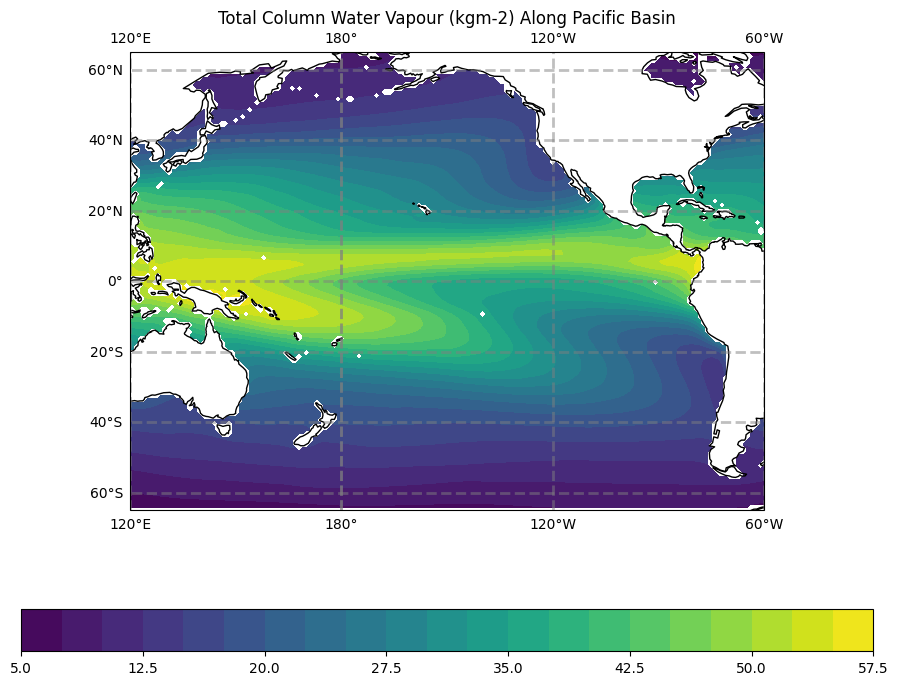

In [141]:
lonW = 120
lonE = 300
latS = -65
latN = 65


crs0 = ccrs.PlateCarree(central_longitude=0)
crs_pacific = ccrs.PlateCarree(central_longitude=-150)

res = '110m'
fig = plt.figure(figsize=(11, 8.5))
ax = plt.subplot(1, 1, 1, projection=crs_pacific)
ax.set_title('Total Column Water Vapour (kgm-2) Along Pacific Basin')
gl = ax.gridlines(
    draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--'
)
ax.set_extent([lonW, lonE, latS, latN], crs=crs0)
ax.coastlines(resolution=res, color='black')
lon, lat = np.meshgrid(total_column_water_vapor_lsm["lon"].to_numpy(),
                       total_column_water_vapor_lsm["lat"].to_numpy())
data = total_column_water_vapor_lsm.to_dataframe().to_numpy().reshape(lat.shape)
# print(lat.shape)
# print(lon.shape)

dataplot = ax.contourf(lon, lat, data, transform=crs0, levels=20)
plt.colorbar(dataplot, orientation="horizontal")

In [28]:
sst_avg

<xarray.DataArray 'Sea_surface_temperature_surface_Mixed_intervals_Average' (
                                                                             time: 516,
                                                                             lat: 130,
                                                                             lon: 181)> Size: 49MB
dask.array<getitem, shape=(516, 130, 181), dtype=float32, chunksize=(120, 130, 181), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 520B 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 724B 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time     (time) datetime64[ns] 4kB 1979-01-16T12:00:00 ... 2021-12-16T12:...
    reftime  (time) datetime64[ns] 4kB dask.array<chunksize=(516,), meta=np.ndarray>
Attributes: (12/15)
    long_name:                       Sea surface temperature (Mixed_intervals...
    units:                           K
    description:                     v-component of wind
    grid_mapping:                    LatLon_Projection
    Grib_Statistical_Interval_Type:  Average
    Grib_Variable_Id:                VAR_98-0-128-34_L1_Imixed_S123
    ...                              ...
    Grib1_Parameter:                 34
    Grib1_Parameter_Name:            sst
    Grib1_Level_Type:                1
    Grib1_Level_Desc:                Ground or water surface
    Grib1_Interval_Type:             123
    Grib1_Interval_Name:             Average of N uninitialized analyses, int...

In [116]:
sst_avg= sst_avg/10

In [117]:
#Finding Analomies Jan 1979-Dec 2023 
clm = (sst_avg.sel(time=slice('1979-01-01','2021-12-31')).groupby('time.month').mean(dim='time'))


In [118]:
anm = (sst_avg.groupby('time.month')-clm)


c:\ATMS523\time-series-and-eofs-samikshyapantha\.venv\Lib\site-packages\xarray\core\indexing.py:1430: PerformanceWarning: Slicing with an out-of-order index is generating 43 times more chunks
  return self.array[key]


In [119]:
anm

<xarray.DataArray 'Sea_surface_temperature_surface_Mixed_intervals_Average' (
                                                                             time: 516,
                                                                             lat: 130,
                                                                             lon: 181)> Size: 49MB
dask.array<sub, shape=(516, 130, 181), dtype=float32, chunksize=(1, 130, 181), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 520B 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 724B 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time     (time) datetime64[ns] 4kB 1979-01-16T12:00:00 ... 2021-12-16T12:...
    reftime  (time) datetime64[ns] 4kB dask.array<chunksize=(516,), meta=np.ndarray>
    month    (time) int64 4kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12

In [121]:
# Detrending function definition
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

# Your dataset is called anm
# Perform detrending
detrended_anm = detrend_dim(anm, dim='time', deg=1)
detrended_anm_SD = detrended_anm/detrended_anm.std(dim='time').compute()


In [136]:
3) Perform an EOF analysis (with cosine latitude weighting) on the SST anomalies and plot a map of the first 5 EOFs.
from eofs.xarray import Eof
from eofs.examples import example_data_path

In [ ]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(detrended_anm_SD.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(detrended_anm_SD, weights=wgts)
